In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [4]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

In [162]:
TRAIN_LAB_PATH = "./data/train_labels.csv"
PREPROCESSED_TRAINING = "./data/preprocessed_interpolated.npy"
PREPROCESSED_KAGGLE = "./data/processed_kaggle_interpolated.npy"

In [163]:
CATEGORIES = ['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose', 'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear', 'pencil', 'penguin', 'pillow', 'pineapple', 'pool', 'rabbit', 'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion', 'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon', 'squiggle']

def getIndexOf(category):
    return CATEGORIES.index(category)

def getCategoryOf(index):
    return CATEGORIES[index]

def load(infile):
    unformatted_images = np.load(infile, encoding='bytes')
    formatted = []
    for i,img in enumerate(unformatted_images):
        formatted.append([i, img[0]])
    return formatted

def formatXData(X):
    X = np.asarray(X)
    # Convert to matrix form
    X = X.reshape(-1, 40, 40, 1)
    # Convert to float
    X = X.astype('float32')
    # Scale pixel values between 0 and 1
    X = X / 255
    return X.astype('float32')

def addRotations(X,y):
    newX = []
    newY = []
    for i,XMatrix in enumerate(X):
        newX.append(XMatrix)
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 1))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 2))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 3))
        newY.append(y[i])
    return np.asarray(newX),np.asarray(newY)

def formatData(images, labels):
    categories = list(set(labels['Category']))
    X = []
    y = []
    for i, img in enumerate(images):
        label = labels.at[i,'Category']
        categoryNum = getIndexOf(label)
        X.append(img[1])
        y.append(categoryNum)
    y = to_categorical(y)
    X = formatXData(X)
    return X.astype('float32'), y

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
    return X_train, y_train, X_test, y_test, X_val, y_val


In [164]:
training_imgs = load(PREPROCESSED_TRAINING)

In [165]:
labels = pd.read_csv(TRAIN_LAB_PATH)

In [166]:
X,y = formatData(training_imgs, labels)

In [167]:
# X,y = addRotations(X,y)

In [168]:
X_train, y_train, X_test, y_test, X_val, y_val = split(X,y)

In [169]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [170]:
batch_size = 64
epochs = 40
num_classes = len(CATEGORIES)
input_shape = (40, 40, 1)

In [185]:
def createModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))

    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

def createModel2():
        # INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC
    model = Sequential()
    #Input
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model


In [175]:
model = createModel2()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 13, 13, 128)       147584    
__________

In [176]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

Train on 6000 samples, validate on 2000 samples
Epoch 1/40
6000/6000 [==============================] - 57s 9ms/step - loss: 3.1225 - acc: 0.1077 - val_loss: 2.7381 - val_acc: 0.1910
Epoch 2/40
6000/6000 [==============================] - 55s 9ms/step - loss: 2.5124 - acc: 0.2620 - val_loss: 2.3751 - val_acc: 0.3175
Epoch 3/40
6000/6000 [==============================] - 55s 9ms/step - loss: 2.1611 - acc: 0.3685 - val_loss: 2.0123 - val_acc: 0.4335
Epoch 4/40
6000/6000 [==============================] - 58s 10ms/step - loss: 1.8759 - acc: 0.4463 - val_loss: 1.7991 - val_acc: 0.5025
Epoch 5/40
6000/6000 [==============================] - 55s 9ms/step - loss: 1.6230 - acc: 0.5267 - val_loss: 1.7602 - val_acc: 0.5135
Epoch 6/40
6000/6000 [==============================] - 53s 9ms/step - loss: 1.4541 - acc: 0.5737 - val_loss: 1.6203 - val_acc: 0.5570
Epoch 7/40
6000/6000 [==============================] - 53s 9ms/step - loss: 1.3022 - acc: 0.6148 - val_loss: 1.6452 - val_acc: 0.5625
Epoch 

In [177]:
score

[1.9966335020065307, 0.666]

In [178]:
import csv
import matplotlib.pyplot as plt
import time

In [179]:
preprocessed_kaggle = load(PREPROCESSED_KAGGLE)
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model.predict(X_kaggle)

def savePredictions(outfile, predictions):
    with open(outfile,'w') as csvfile:
        fieldnames = ['Id', 'Category']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, prediction in enumerate(predictions):
            index = np.argmax(prediction)
            writer.writerow({'Id': i, 'Category': getCategoryOf(index)})    

In [278]:
def visualizePredictions(images, predictions, start = 0, end = 10):
    fig, ax = plt.subplots(figsize=(len(CATEGORIES) + 1, 30))

    for i in list(range(start, end)):

        # plot probabilities:
        ax = plt.subplot2grid((end - start, 5), (i - start, 0), colspan=4);
        plt.bar(np.arange(len(CATEGORIES)), predictions[i], 0.35, align='center');
        plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES)
        plt.tick_params(axis='x', bottom='off', top='off')
        plt.ylabel('Probability')
        plt.ylim(0,1)
        plt.subplots_adjust(hspace = 0.5)

        # plot picture:
        ax = plt.subplot2grid((end - start, 5), (i - start, 4));
        plt.imshow(images[i][1].reshape((40,40)),cmap='gray_r', interpolation='nearest');
        plt.xlabel(getCategoryOf(np.argmax(predictions[i]))); # get the label from the dict
        plt.xticks([])
        plt.yticks([])

#     for i, img in enumerate(images):
#         img = img[1].reshape((40,40)).astype(np.uint8)
#         f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
#         f.suptitle(getCategoryOf(np.argmax(predictions[i])))
#         axarr[0].imshow(img, cmap='gray_r')
#         axarr[0].set_title('Image')
#         axarr[1].bar(range(0, len(CATEGORIES)), predictions[i])
#         plt.show()

In [180]:
ts = time.time()
timestamp = int(ts)
savePredictions('./data/prediction_'+ str(timestamp) + '_' + str(score[1]) + '.csv', kaggle_predictions)

In [259]:
training_imgs = load(PREPROCESSED_TRAINING)
X,y = formatData(training_imgs, labels)
X_train, y_train, X_test, y_test, X_val, y_val = split(X,y)

In [260]:
model = createModel()
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_130 (Dropout)        (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 6, 6, 128)         73856     
_________________________________________________________________
dropout_131 (Dropout)        (None, 6, 6, 128)         0         
__________

In [261]:
score

[1.4229669852256774, 0.6525]

In [263]:
preprocessed_kaggle_1 = load(PREPROCESSED_KAGGLE)
X_kaggle_1 = formatXData(list(map(lambda x: x[1], preprocessed_kaggle_1)))
kaggle_predictions_1 = model.predict(X_kaggle_1)

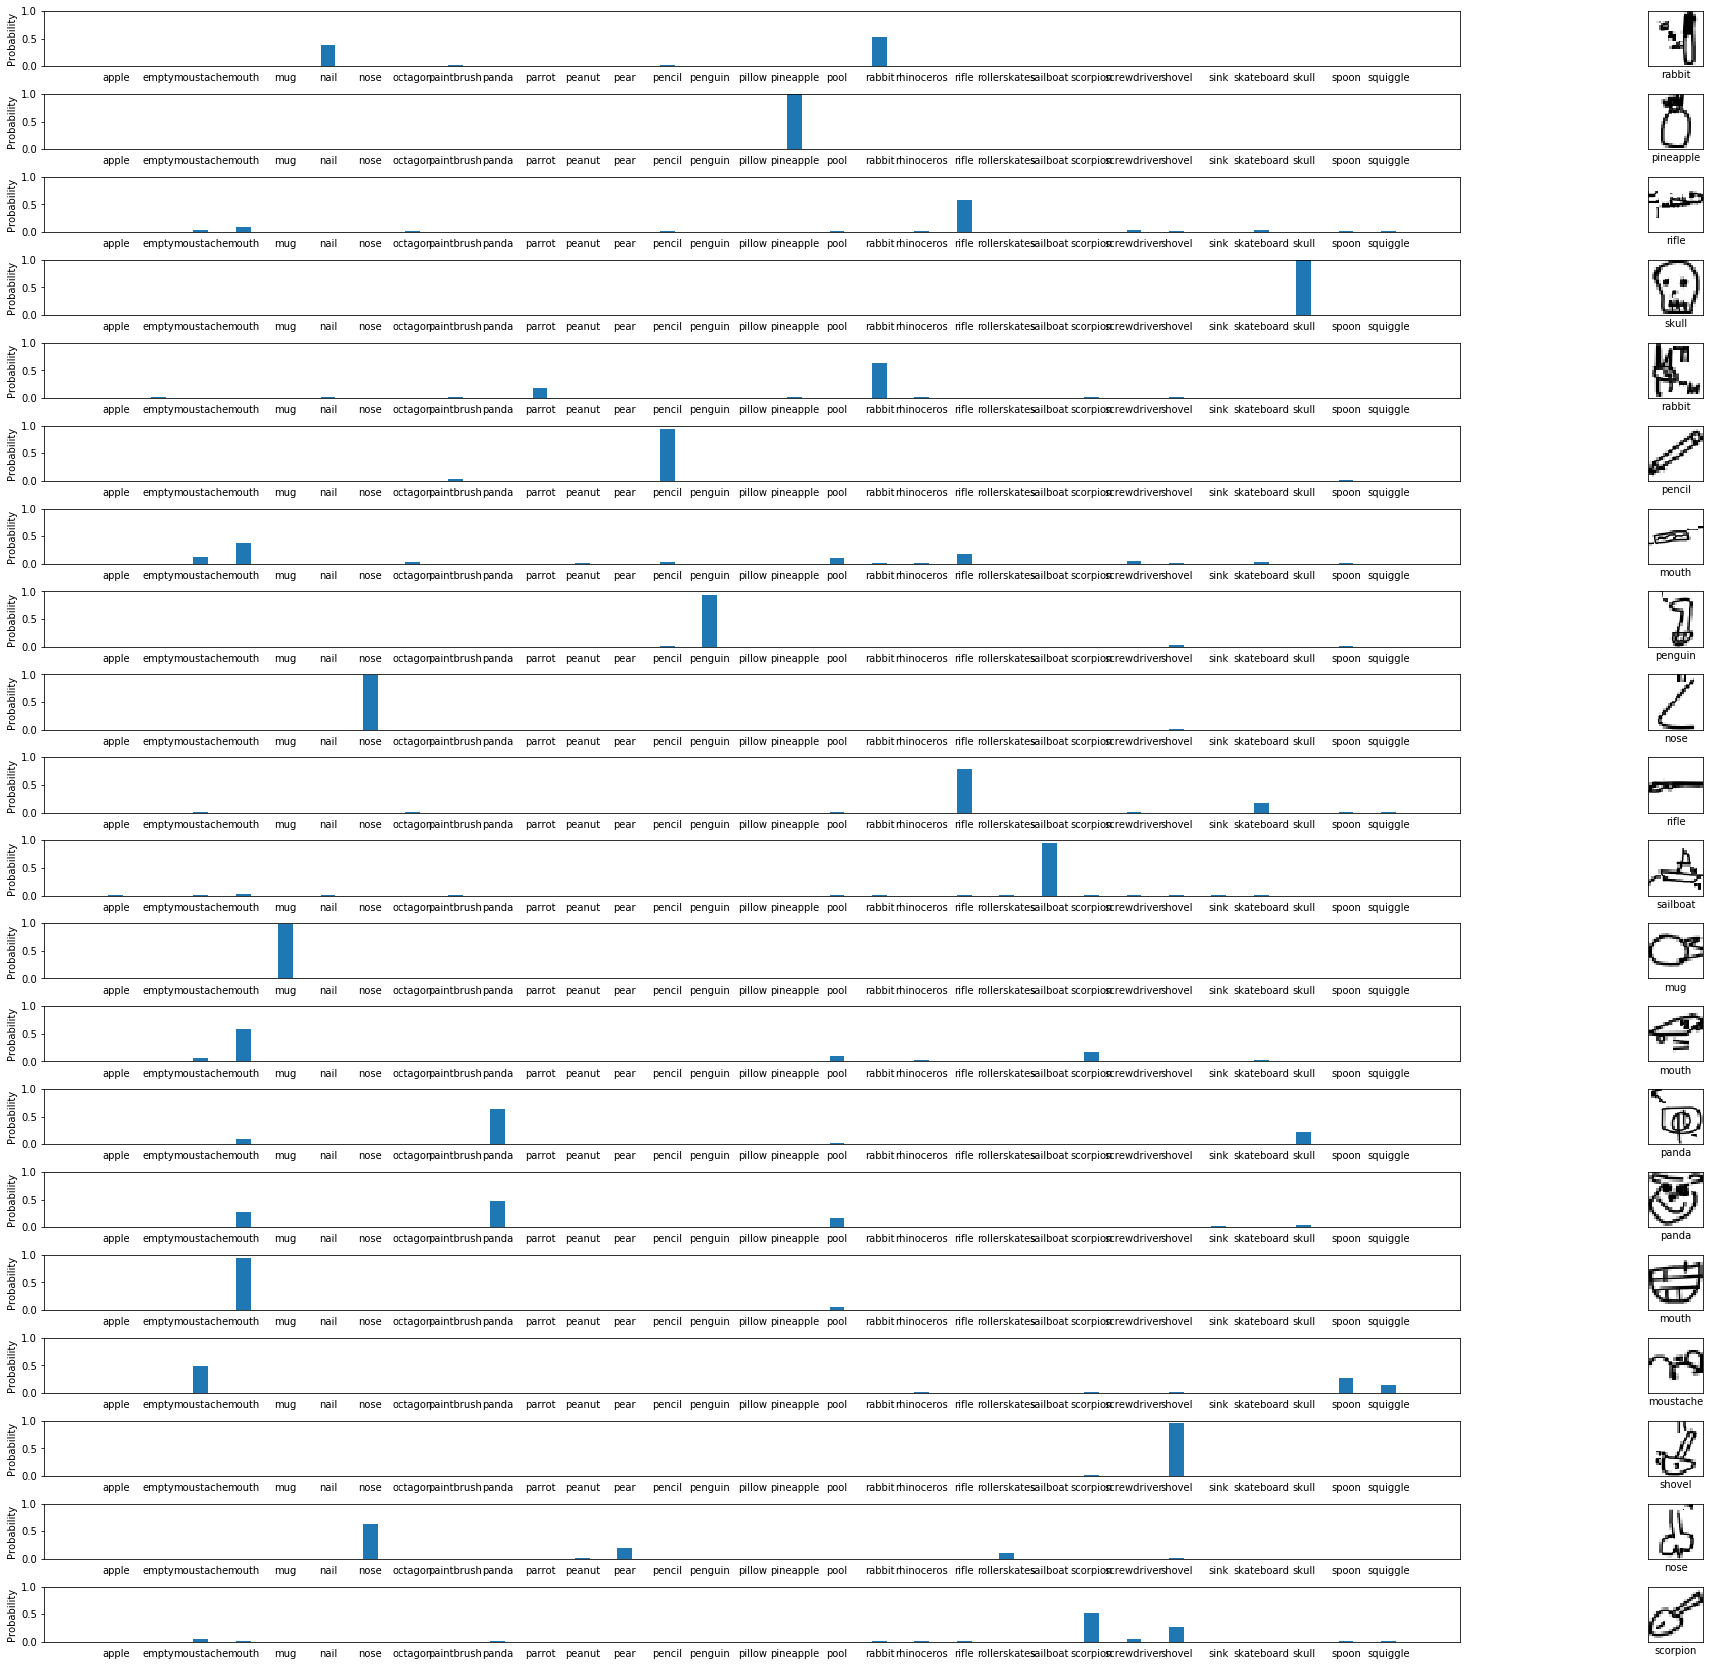

In [279]:
visualizePredictions(preprocessed_kaggle_1,kaggle_predictions_1, 10, 30)

In [189]:
ts = time.time()
timestamp = int(ts)
savePredictions('./data/prediction_'+ str(timestamp) + '_' + str(score[1]) + '.csv', kaggle_predictions)

# Interpolated AND bounded

In [293]:
PREPROCESSED_TRAINING_BI = "./data/preprocessed_interpolated_bounded.npy"
PREPROCESSED_KAGGLE_BI = "./data/processed_kaggle_interpolated_bounded.npy"

In [294]:
training_imgs_bi = load(PREPROCESSED_TRAINING_BI)
X,y = formatData(training_imgs_bi, labels)
X_train, y_train, X_test, y_test, X_val, y_val = split(X,y)
model_bi = createModel()
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model_bi.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_138 (Dropout)        (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 6, 6, 128)         73856     
_________________________________________________________________
dropout_139 (Dropout)        (None, 6, 6, 128)         0         
__________

In [297]:
score = model_bi.evaluate(X_test, y_test, verbose=0)
score

[3.4549782485961913, 0.0355]

In [291]:
preprocessed_kaggle_bi = load(PREPROCESSED_KAGGLE_BI)
X_kaggle_bi = formatXData(list(map(lambda x: x[1], preprocessed_kaggle_bi)))
kaggle_predictions_bi = model_bi.predict(X_kaggle_bi)

In [284]:
ts = time.time()
timestamp = int(ts)
savePredictions('./data/prediction_'+ str(timestamp) + '_' + str(score[1]) + '.csv', kaggle_predictions)

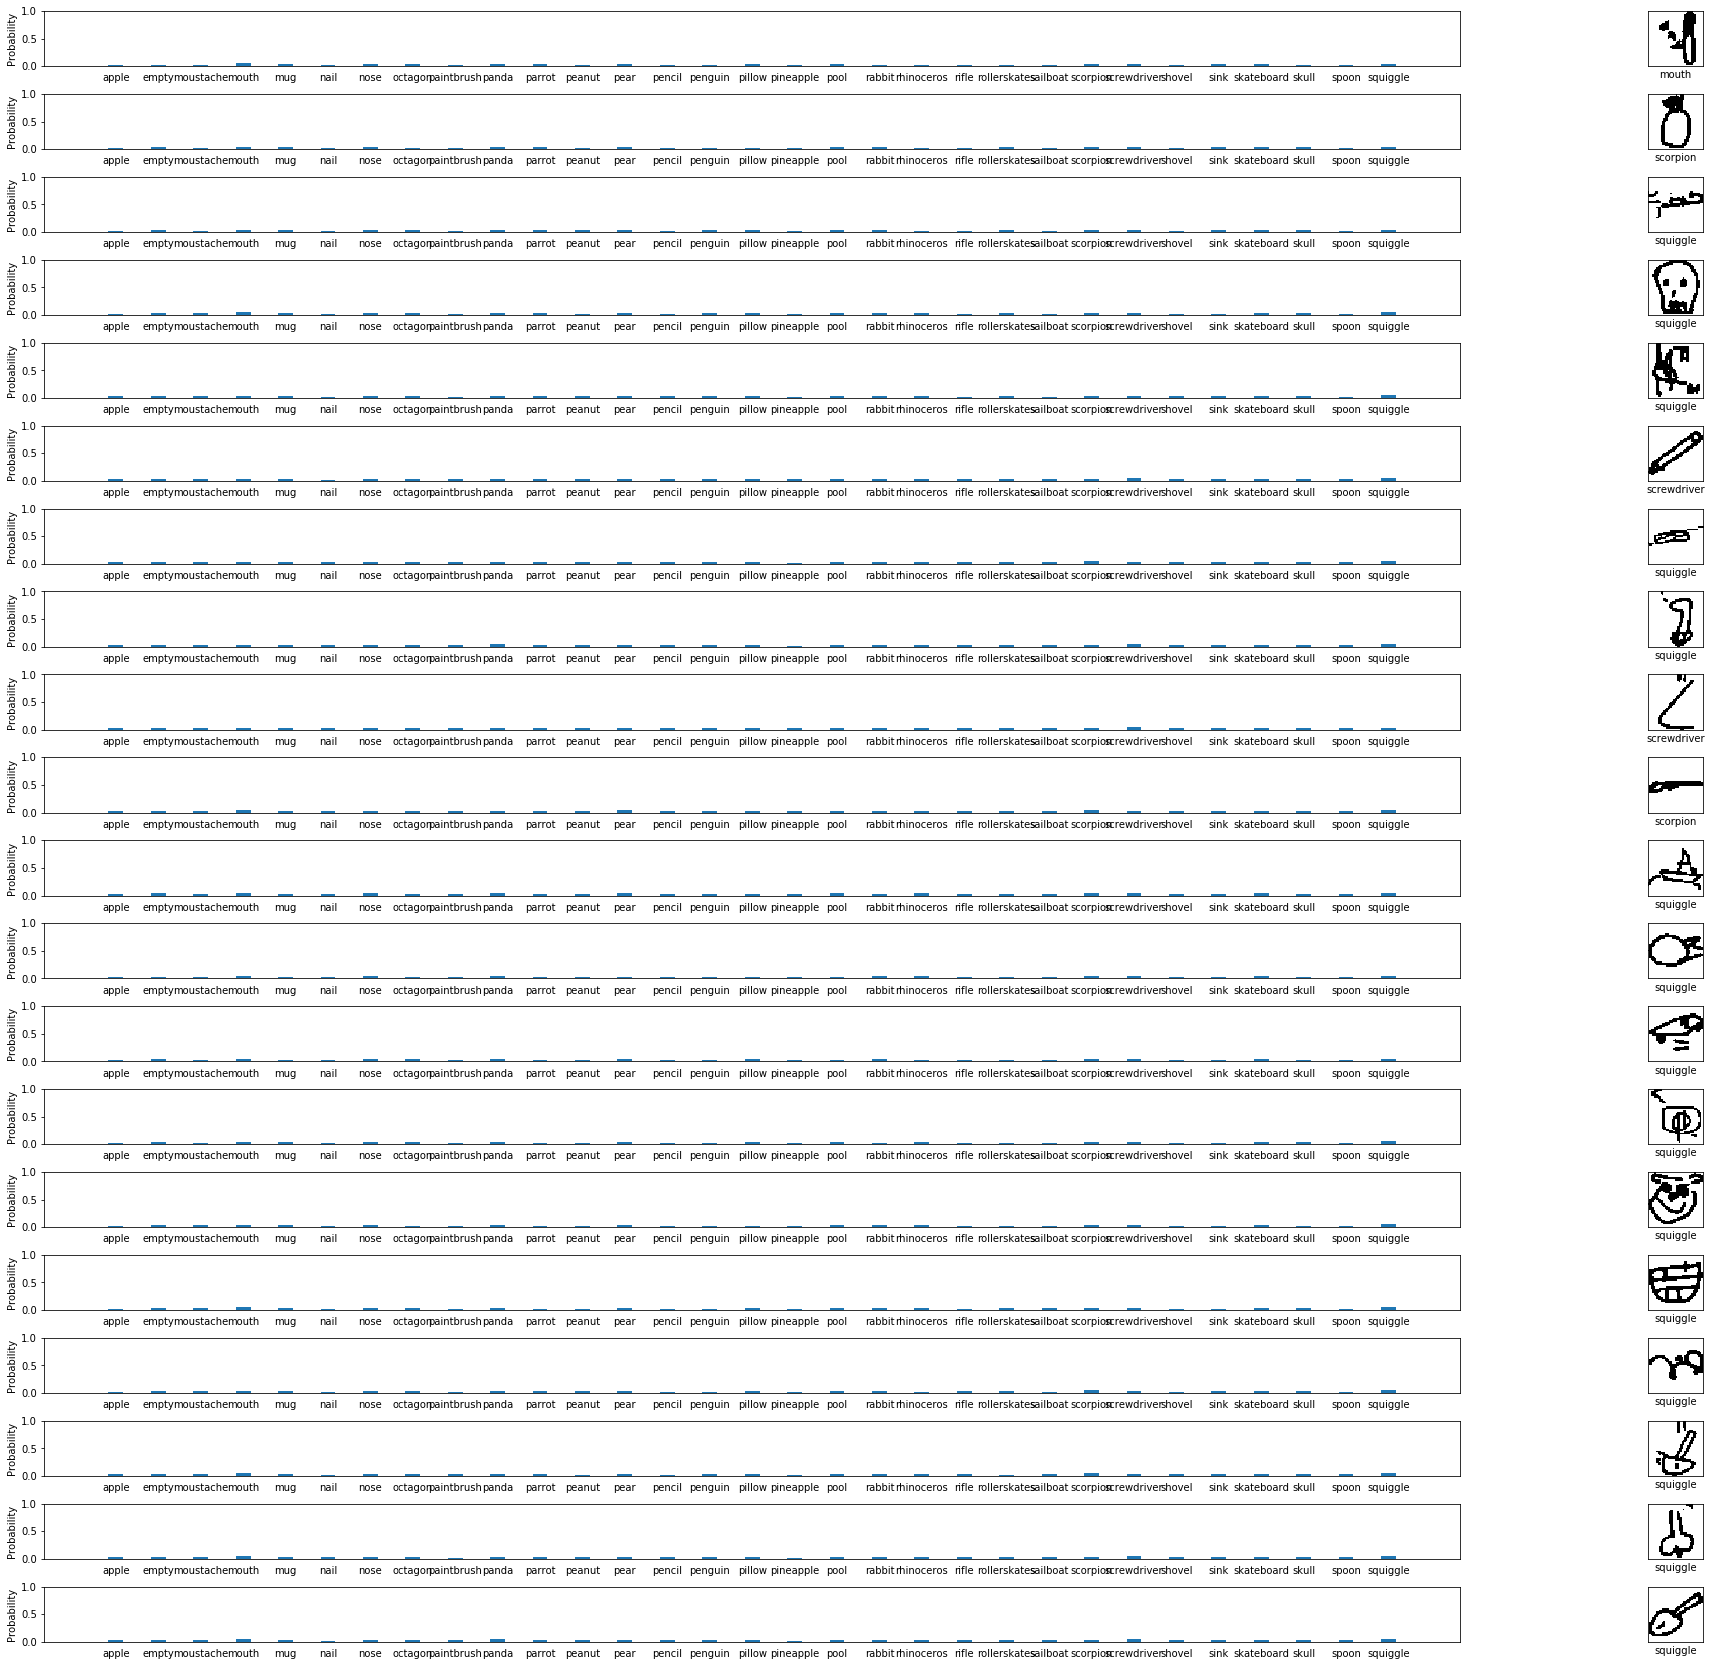

In [292]:
visualizePredictions(preprocessed_kaggle_bi,kaggle_predictions_bi, 10, 30)

In [230]:
model = createModel2()
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_143 (Conv2D)          (None, 38, 38, 32)        320       
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_121 (Dropout)        (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 13, 13, 128)       147584    
__________

In [231]:
score

[2.05893856048584, 0.6475]

In [232]:
kaggle_predictions = model.predict(X_kaggle)

In [233]:
ts = time.time()
timestamp = int(ts)
savePredictions('./data/prediction_'+ str(timestamp) + '_' + str(score[1]) + '.csv', kaggle_predictions)

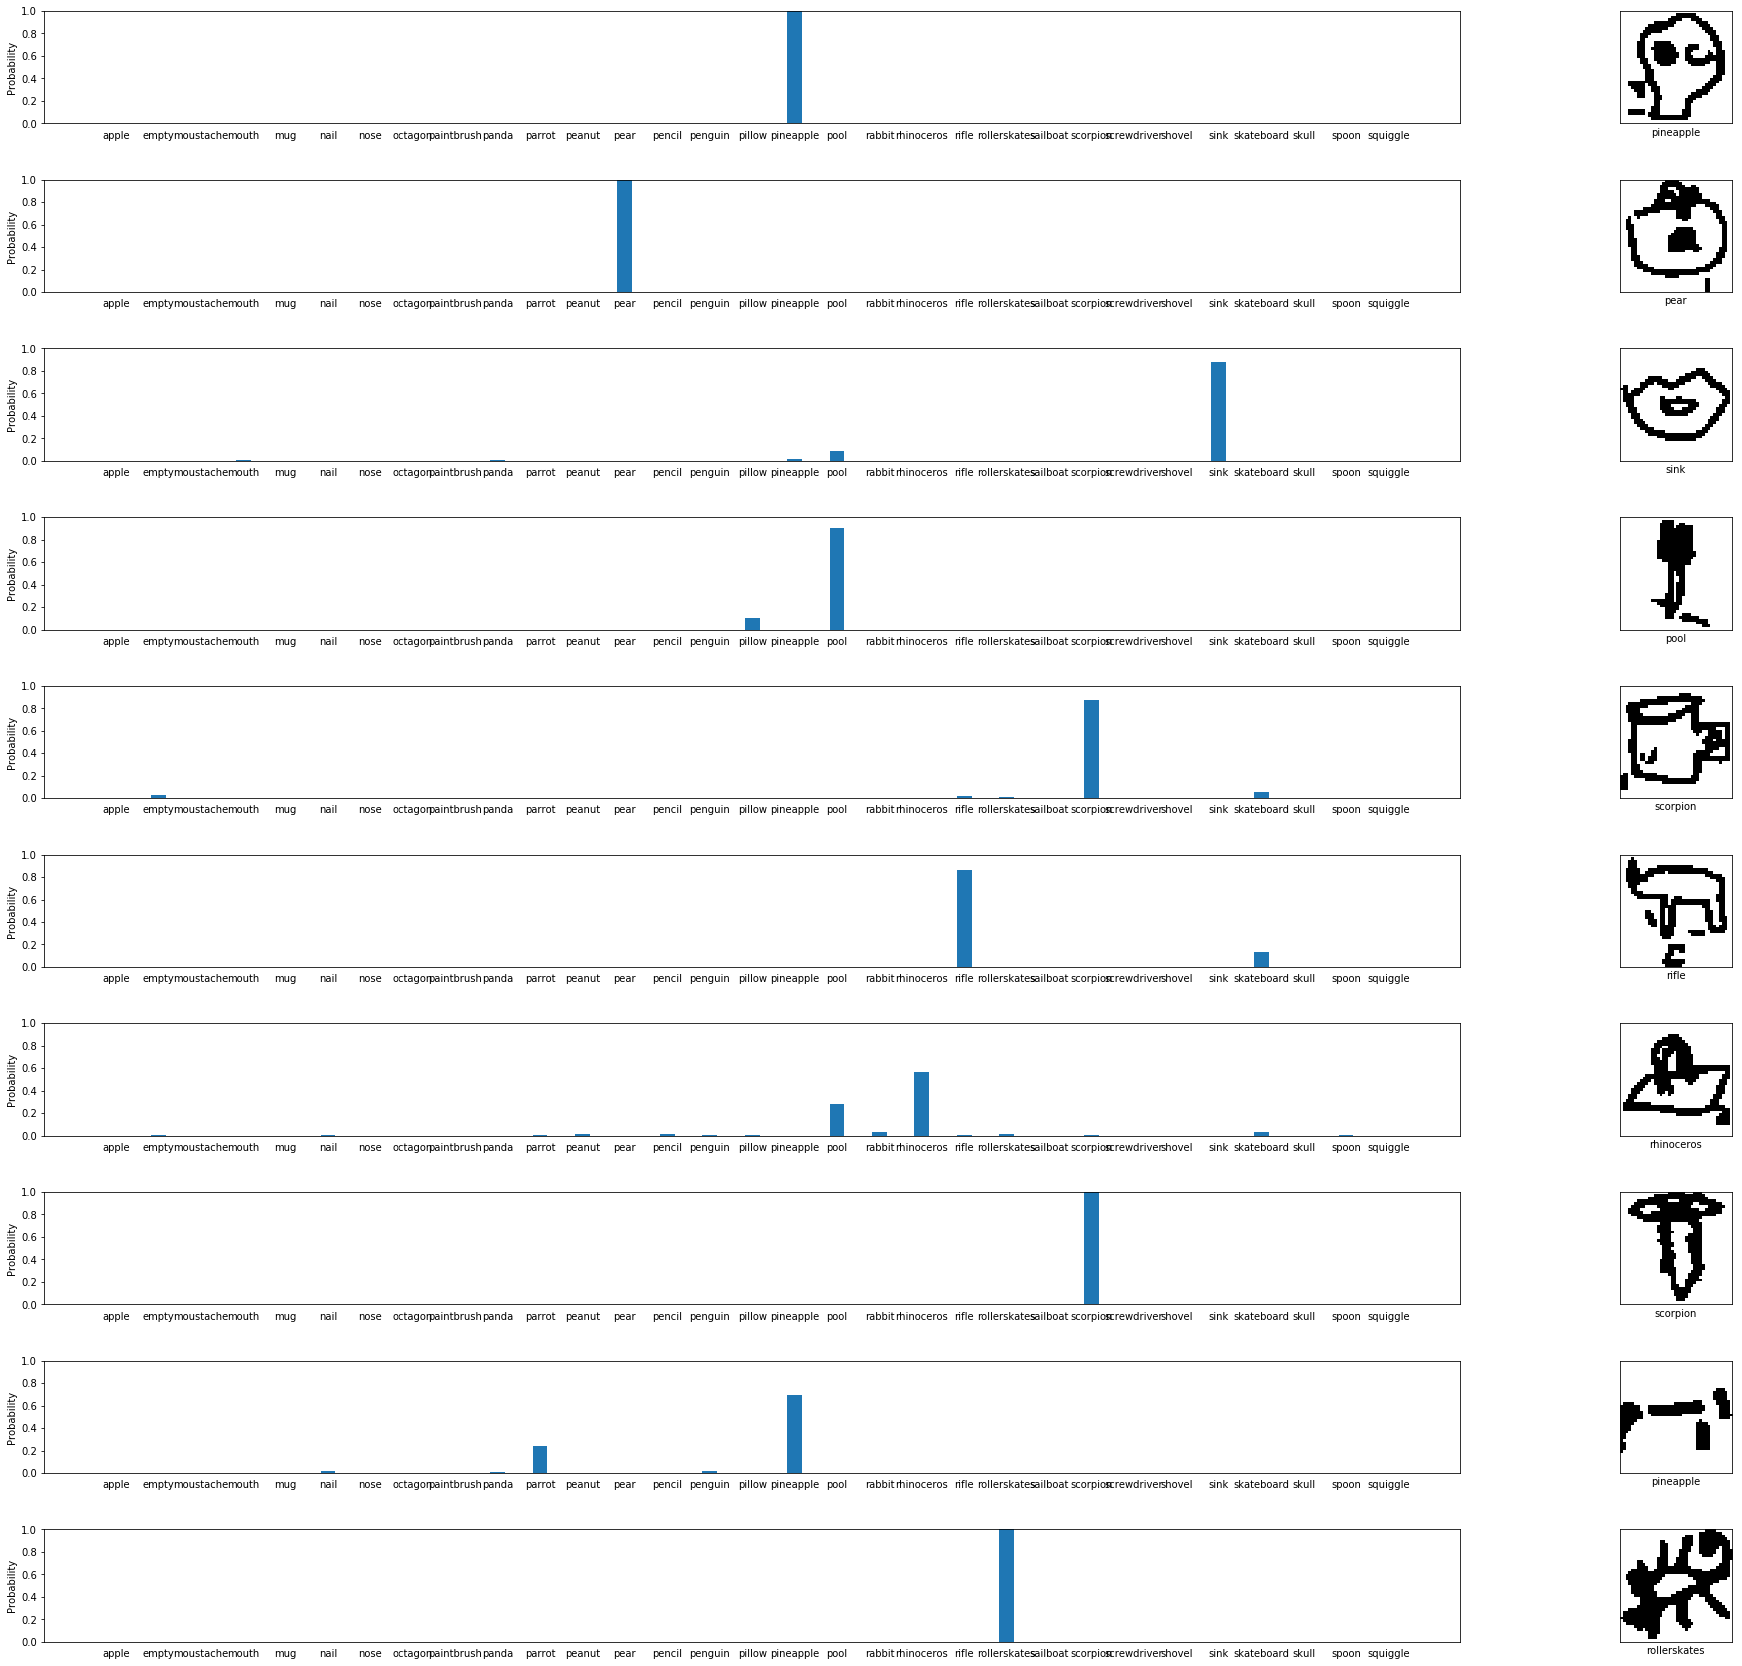

In [256]:
visualizePredictions(preprocessed_kaggle[:100],kaggle_predictions[:100])

In [241]:
# Grabbed from: https://github.com/kradolfer/quickdraw-image-recognition/blob/master/quickdraw_image_recognition.ipynb
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(42, (5, 5), input_shape=(40, 40, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [242]:
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test, y_test, verbose=0)

Train on 6000 samples, validate on 2000 samples
Epoch 1/40
6000/6000 [==============================] - 8s 1ms/step - loss: 3.2108 - acc: 0.1033 - val_loss: 2.7961 - val_acc: 0.2155
Epoch 2/40
2400/6000 [===========>..................] - ETA: 3s - loss: 2.7181 - acc: 0.2471

KeyboardInterrupt: 